# Homework4, Model Selection, Transformer (4 + 3 + 19 = 26 points)

**Submission Note:** You do not need to upload your transformer model checkpoint, it is too large.

In this exercise, we are going to explore different model selection methods. Specifically, we are considering the Hold-out methods and cross-validation.

In [249]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Let's start by creating a toy data set: A third order polynomial where the training data is noisy

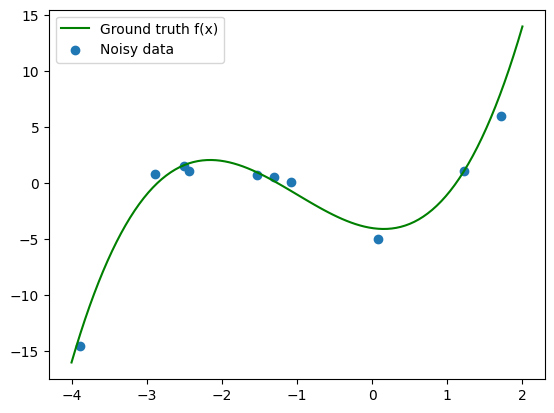

In [250]:
np.random.seed(33)
n = 3
x = np.linspace(-4, 2, 101)  # for plotting

p_gt = [1, 3, -1, -4]  # coefficients for a third order polynome
y_gt = np.polyval(p_gt, x)  # = p[0] * x**n + p[1] * x**(n-1) + ...

n_data = 10  # create 10 data points
x_data = np.random.uniform(-4, 2, n_data)
y_data_gt = np.polyval(p_gt, x_data)
y_data = y_data_gt + 1 * np.random.randn(n_data)

plt.plot(x, y_gt, color='g', label="Ground truth f(x)")
plt.scatter(x_data, y_data, label="Noisy data")
plt.legend()

## Exercise 1: Polynomial Regression using Hold-Out Validation (4P)
In this exercise, you will use the hold-out validation method to train and validate polynomial regression models of different orders. Your goal is to determine the optimal model complexity by minimizing the validation mean squared error (MSE).

Best model order: 3


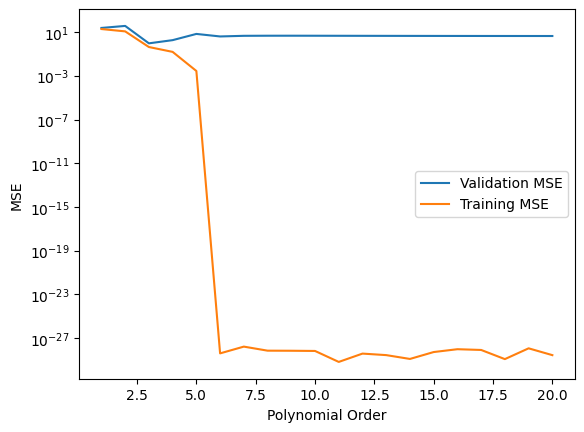

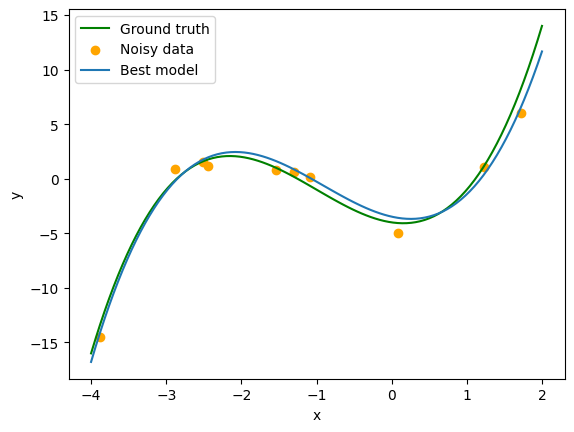

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# Assume the following data is provided:
# x_data, y_data: arrays containing the input data points and corresponding noisy outputs
# x: array of points for plotting the ground truth and best model
# y_gt: array of ground truth values corresponding to x

M = 20  # Maximum order of polynomials to train
models = np.arange(1, M+1)
MSEs = []
mse_trains = []

split = 0.7  # Proportion of data to use for training
n_data = len(x_data)
split_ind = int(split * n_data)

# 1: Split into training and validation sets
ind = np.random.choice(n_data, n_data, replace=False)  # Shuffle data indices
ind_train = ind[:split_ind]
ind_val = ind[split_ind:]
D_T = {"x": x_data[ind_train], "y": y_data[ind_train]}  # Training data
D_V = {"x": x_data[ind_val], "y": y_data[ind_val]}  # Validation data

# Loop through polynomial orders and train models
for m in models:
    ########## TODO ##########
    # 2: Train on training data
    p = np.polyfit(D_T["x"], D_T["y"], m) # (Hint: you can use np.polyfit)
    ##########################

    ########## TODO ##########
    # Evaluate on validation data
    errors = (np.polyval(p, D_V["x"]) - D_V["y"])**2
    MSE = np.average(errors)  # (Hint: you can use np.polyval)
    MSEs.append(MSE)
    ##########################

    ########## TODO ##########
    # Compute MSE on training data for comparison
    errors = (np.polyval(p, D_T["x"]) - D_T["y"])**2
    mse_train = np.average(errors)
    mse_trains.append(mse_train)
    ##########################

    # Log parameters of the best model order
    if MSE <= np.min(MSEs):
        p_best = p

########## TODO ##########
# 4: Pick model with best validation loss
m_star = len(p_best)-1
print("Best model order: {}".format(m_star))
##########################

# Plotting MSE for training and validation sets
plt.figure()
plt.semilogy(models, MSEs, label="Validation MSE")
plt.semilogy(models, mse_trains, label="Training MSE")
plt.xlabel("Polynomial Order")
plt.ylabel("MSE")
plt.legend()

# Plotting the ground truth, data points, and best model
plt.figure()
plt.plot(x, y_gt, color='g', label="Ground truth")
plt.scatter(x_data, y_data, color='orange', label="Noisy data")
f_hat = np.polyval(p_best, x)
plt.plot(x, f_hat, label="Best model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Exercise 2: Polynomial Regression using k-Fold Cross-Validation
In this exercise, you will use the k-fold cross-validation method to train and validate polynomial regression models of different orders. Your goal is to determine the optimal model complexity by minimizing the mean squared error (MSE).

### Exercise 2.1: Implement k-Fold Cross-Validation (2p)

In [252]:
def k_fold_cv(x, y, m, k):
    """
    k-fold cross validation method
    :param x: samples
    :param y: targets
    :param m: model order
    :param k: number of partitions
    :return mean MSE of test and training set
    """
    n_data = y.size
    if k > n_data:
        k = n_data

    MSEs_test = []
    MSEs_train = []
    
    n_val_data = n_data // k  # how many data points are in validation set
    rand_ind = np.random.choice(n_data, n_data, replace=False)  # random indices in [1, n] to shuffle data
    
    # loop over partitions
    for k_ in range(k):

        ########## TODO ##########
        # 1: Split into training and validation dataset (Hint: You may use n_val_data and rand_int defined above the for-loop)
        val_start = k_*n_val_data
        ind_val = rand_ind[val_start:val_start+n_val_data] # indices for validation data
        ind_train = np.concatenate((rand_ind[:val_start], rand_ind[val_start+n_val_data:])) # indices for train data
        ##########################
        
        # Training data set
        D_T = {"x": x[ind_train],
               "y": y[ind_train]}
        
        # Validation data set
        D_V = {"x": x[ind_val],
               "y": y[ind_val]}
    
        ########## TODO ##########
        # 2: Train and evaluate again on training data to obtain estimator
        # Hint: look at the hold out method and use built in numpy functions like polyfit and polyval
        p = np.polyfit(D_T["x"], D_T["y"], m)
        errors = (np.polyval(p, D_V["x"]) - D_V["y"])**2
        MSE_test = np.average(errors) 
        errors = (np.polyval(p, D_T["x"]) - D_T["y"])**2
        MSE_train = np.average(errors) 
        ##########################
        
        MSEs_test.append(MSE_test)
        MSEs_train.append(MSE_train)
        
    return np.mean(MSEs_test), np.mean(MSEs_train)

Best model complexity: 3
MSE: 2.9258452666419035


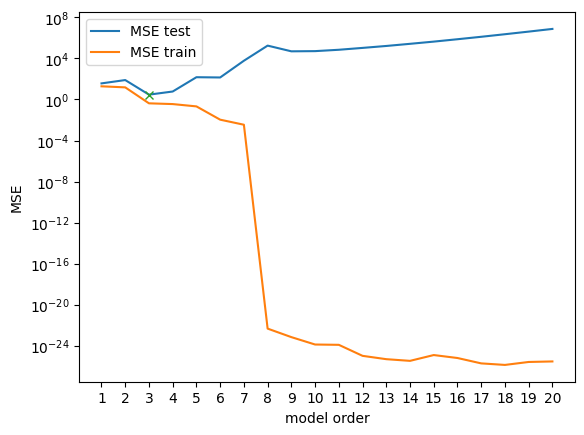

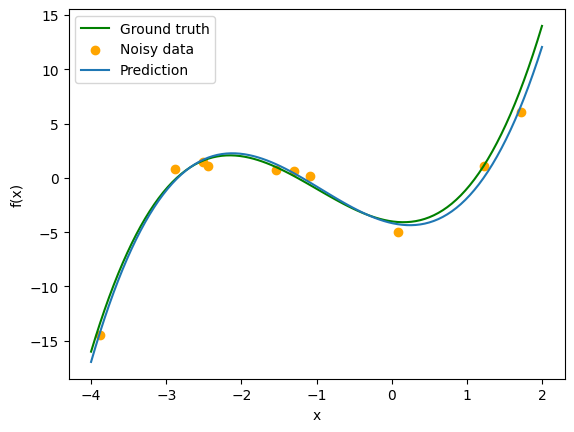

In [253]:
M = 20  # train polynomials up to order M
models = np.arange(1, M+1)
k = 10  # number of partitions, choose from 2 ... 10
MSEs_test = []
MSEs_train = []

for m in models:
    mse_test, mse_train = k_fold_cv(x_data, y_data, m, k)
    MSEs_test.append(mse_test)
    MSEs_train.append(mse_train)
    
m_star = models[np.argmin(MSEs_test)]
print("Best model complexity:", m_star)
print("MSE:", np.min(MSEs_test))
plt.semilogy(models, MSEs_test, label="MSE test")
plt.semilogy(models, MSEs_train, label="MSE train")
plt.semilogy(m_star, np.min(MSEs_test), "x")
plt.xticks(models)
plt.xlabel("model order")
plt.ylabel("MSE")
plt.legend()

p_cv = np.polyfit(x_data, y_data, m_star)
y_cv = np.polyval(p_cv, x)

plt.figure()
plt.plot(x, y_gt, color='g', label="Ground truth")
plt.scatter(x_data, y_data, label="Noisy data", color="orange")
plt.plot(x, y_cv, label="Prediction")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()

### Exercise 2.2: Partition Sizes (1p)
What is the influence of the number of partitions (folds) on the variance of the MSE? Why is that the case? Hint: Use the code below!

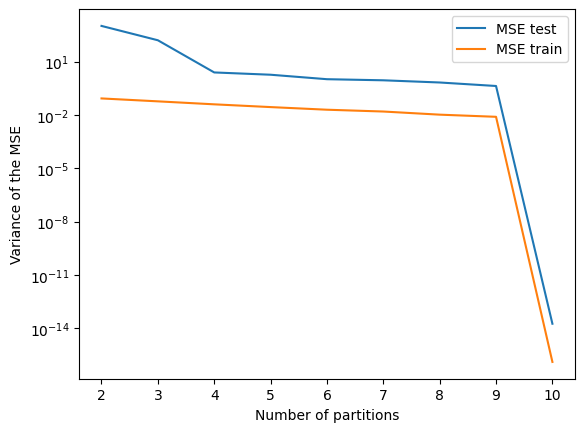

In [254]:
m = 3  # try different model orders
partitions = np.arange(2, 10+1)
MSEs_test_list = []
MSEs_train_list = []
MSEs_test_mean = []
MSEs_train_mean = []
MSEs_test_std = []
MSEs_train_std = []

# for different partition sizes, run k-fold cross validation 100 times
# and record the mean and standard deviation of
# the MSE of the train and test set
for k in partitions:
    for i in range(100):
        mse_test_i, mse_train_i = k_fold_cv(x_data, y_data, m, k)
        MSEs_test_list.append(mse_test_i)
        MSEs_train_list.append(mse_train_i)
    MSEs_test_mean.append(np.mean(MSEs_test_list))
    MSEs_train_mean.append(np.mean(MSEs_train_list))
    MSEs_test_std.append(np.std(MSEs_test_list))
    MSEs_train_std.append(np.std(MSEs_train_list))
    MSEs_test_list = []
    MSEs_train_list = []
    
MSEs_test_mean = np.hstack(MSEs_test_mean)
MSEs_train_mean = np.hstack(MSEs_train_mean)
MSEs_test_std = np.hstack(MSEs_test_std)
MSEs_train_std = np.hstack(MSEs_train_std)
    
plt.semilogy(partitions, MSEs_test_std, label="MSE test")
plt.semilogy(partitions, MSEs_train_std, label="MSE train")

plt.xticks(partitions)
plt.xlabel("Number of partitions")
plt.ylabel("Variance of the MSE")
plt.legend()

We can see that the variance decreases with the number of partitions. 

When having a small number of partitions, there are more data points in each partition and therefore the validation partition is larger. So, our model is trained with less data points and the data points for each run vary more, leading to a higher MSE variance.

Having more partitions, on the other hand, leads to smaller partitions. We use more data points for training and less for validation, and the data points vary less. This leads a lower MSE variance as we can see in the plot.

# Exercise 3, Transformer from Scratch (19 Points)
In this task, you will implement a transformer model from scratch, following the original paper ["Attention is All You Need"](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Then you will train it as a German to English translator. We will use the Multi30K dataset which contains 30k simple German-English sentence pairs. Let's firstly take a look of the dataset.

In [255]:
from util import read_lines
train_de = read_lines('data/multi30k/train.de')
train_en = read_lines('data/multi30k/train.en')
valid_de = read_lines('data/multi30k/valid.de')
valid_en = read_lines('data/multi30k/valid.en')

print(f"German : {train_de[3]}")
print(f"English: {train_en[3]}")

German : Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.

English: A man in a blue shirt is standing on a ladder cleaning a window.



---

We need several pre-processing steps for the dataset, so that we can train our model on it. These steps include:
1. Get the vocabulary dictionaries for both German and English
2. Tokenize the sentences using the vocabulary dictionaries
3. Create PyTorch datasets and dataloaders
---
To do so, we will use the pre-defined tokenizer from the library spacy (https://spacy.io/). We need to install it and download the German and English tokenizer models. You can do so by running the following commands. 
```bash
pip install spacy
python -m spacy download de_core_news_sm    # German tokenizer
python -m spacy download en_core_web_sm     # English tokenizer
```
Some previous versions of `spacy` require that numpy's version <2.0 (if you run in to issues, downgrade numpy).
---
After that, you can use the following code to build the vocabularies dictionaries.

In [256]:
from util import build_vocab, tokenize_de, tokenize_en
vocab_de = build_vocab(train_de, tokenize_de)
vocab_en = build_vocab(train_en, tokenize_en)

Let's see how vocabulary dictionary looks like. Try search the word "Mannschafft" in the German vocabulary dictionary and the "football" in the English dictionary.

In [257]:
print(f"Index of {'Mannschaft'} in the German vocabulary dictionary is {vocab_de['Mannschaft']}")
print(f"Index of {'football'} in the English vocabulary dictionary is {vocab_en['football']}")

Index of Mannschaft in the German vocabulary dictionary is 963
Index of football in the English vocabulary dictionary is 1596


---
We also have 4 special tokens in the vocabulary dictionaries:
1. \<unk\> for unknown words (words do not exist in spacy tokenizer)
2. \<pad\> for padding words
3. \<bos\> for the beginning of the sentence
4. \<eos\> for the end of the sentence

The padding is used when the length of a sentence is shorter than the maximum length of sentences in the mini-batch. For example, if we have 'Hello world.' and 'Machine learning is very cool.' in one mini-batch, we need to pad the shorter sentence 'Hello world.' with three padding tokens '\<pad\>' as follows:

|    0    |    1    |    2     | 3  |    4    |    5    |    6    |    7    |
|:-------:|:-------:|:--------:|:--:|:-------:|:-------:|:-------:|:-------:|
| \<bos\> |  Hello  |  world   | .  | \<eos\> | \<pad\> | \<pad\> | \<pad\> |
| \<bos\> | Machine | learning | is |  very   |  cool   |    .    | \<eos\> |
---

To tokenize the sentences and decode it back, we can use the following python code:

In [258]:
# Sentences to tokens
def encode(text, vocab, tokenizer):
    return [vocab["<bos>"]] + [
        vocab[token] if token in vocab else vocab["<unk>"] for token in
        tokenizer(text)] + [vocab["<eos>"]]

# Tokens to sentences
def decode(tokens, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    return " ".join([inv_vocab[token] for token in tokens if token not in (
        vocab["<bos>"], vocab["<eos>"], vocab["<pad>"])])

In [259]:
# Let's see how the encode and decode functions work
original_german_sentence = train_de[3]
print(f"Original German: {original_german_sentence}")
encoded_german_sentence = encode(original_german_sentence, vocab_de, tokenize_de)
print(f"Tokenized German: {encoded_german_sentence} \n")
decoded_german_sentence = decode(encoded_german_sentence, vocab_de)
print(f"Decoded German: {decoded_german_sentence}")


Original German: Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.

Tokenized German: [2, 24, 31, 11, 32, 33, 34, 35, 36, 37, 38, 39, 40, 22, 41, 16, 17, 3] 

Decoded German: Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster . 



---
To achieve the training of our German to English translator, we need to process each pair of German and English sentences in the dataset. We will use the following code to process the dataset.

In [260]:
import torch

# Encode the German sentence and its corresponding English sentence
def data_process(sentences_de, sentences_en):
    data = []
    for src_text, tgt_text in zip(sentences_de, sentences_en):
        src_tensor_ = torch.tensor(encode(src_text, vocab_de, tokenize_de),
                                   dtype=torch.long)
        tgt_tensor_ = torch.tensor(encode(tgt_text, vocab_en, tokenize_en),
                                   dtype=torch.long)
        data.append((src_tensor_, tgt_tensor_))
    return data


# Create the PyTorch dataset classes
class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)
    
    
# Get the PyTorch datasets instances
train_dataset = TranslationDataset(data_process(train_de, train_en))
valid_dataset = TranslationDataset(data_process(valid_de, valid_en))

---
With the datasets in hand, now we implement our dataloader. Each time, the dataloader will return a mini-batch of the dataset. As each sentence in the mini-batch has a different length, we need a collate function to add padding tokens at the end of the short sentences. We will use the following code to implement the dataloader.

In [261]:
from torch.utils.data import DataLoader
import torch.nn as nn

# Collate function to pad short sentences 
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)
    src_batch = nn.utils.rnn.pad_sequence(src_batch, padding_value=vocab_de[
        "<pad>"]).transpose(0, 1) # The transpose ensures batch first view
    tgt_batch = nn.utils.rnn.pad_sequence(tgt_batch, padding_value=vocab_en[
        "<pad>"]).transpose(0, 1)
    return src_batch, tgt_batch


train_dataloader = DataLoader(TranslationDataset(train_dataset), batch_size=32,
                              shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(TranslationDataset(valid_dataset), batch_size=32,
                              shuffle=True, collate_fn=collate_fn)

---
OK, the data pre-processing part is finished. Now, let's take a look of the transformer architecture. The implementation has the following components:
1. TokenEmbedding
2. **Positional Encoding (your task)**
3. **Multi-Head Attention (your task)**
4. Feed Forward Neural Network
5. Layer Normalization
6. **Encoder Layer (your task)**
7. **Decoder Layer (your task)**
8. Encoder
9. Decoder
10. Transformer

Please note, for consistency to previous homework, we choose to use the **batch first dimensionality manner** in the implementation. This means the shape of a sequence data is always **(batch size, sequence length, ...)**, rather than the one commonly used in natural linear processing(NLP), as (sequence length, batch size, ...).

---
We begin with the TokenEmbedding. It is used to convert the token (vocabulary) index to the corresponding token embedding, namely a high dimensional feature vector (512 in the current homework). The implementation uses the build-in pytorch embedding class and takes the size of the vocabulary (token) dictionary and the size of the embedding. We follow the original paper ["Attention is All You Need"](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) page 5, to scale the embedding by the square root of the embedding size. The class has the following code snippet:

In [262]:
import math

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        """
            tokens: [batch_size, seq_len]
            return: [batch_size, seq_len, emb_size]
        """
        token_embed = self.embedding(tokens.long()) * math.sqrt(self.emb_size)
        return token_embed

## Q 1, Positional Encoding (4 Points)
Next, we need to implement the positional encoding. The positional encoding is used to add the information about the position of the tokens in the sentence, which is later added to the token embedding. It is calculated as follows:

$\large   PE(t, 2l) = sin(\frac{pos}{10000^{2l/d_{\text{model}}}})  $

$\large   PE(t, 2l+1) = cos(\frac{pos}{10000^{2l/d_{\text{model}}}})$

where $t$ is the positional index of the sequence and $l$ is the index of the embedding. The embedding's dimension size is equivalent to the model's dimension $d_{\text{model}}$ of the transformer.
In practice, positional encodings are computed in log-space and uses the exp-log trick to avoid numerical overflow, as:
$\large a^b = \exp(\log(a) \times b)$


In [263]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):        
        super(PositionalEncoding, self).__init__()
        
        # Shape of the positional encoding: (max_len, emb_size)
        self.encoding = torch.zeros(max_len, emb_size)
        self.encoding.requires_grad = False  # No gradients needed
        
        ####################################################################
        # TODO: Implement the positional encoding
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(-math.log(10000) * torch.arange(0, emb_size, 2).float() / emb_size)

        self.encoding[:, 0::2] = torch.sin(pos * div_term)
        self.encoding[:, 1::2] = torch.cos(pos * div_term)
        ####################################################################
        
        # Add additional batch dimension in front, to (1, max_len, emb_size)
        self.encoding = self.encoding.unsqueeze(0) 

    def forward(self, token_embed: torch.Tensor) -> torch.Tensor:
        """
            token_embed: [batch_size, seq_len, emb_size]
            pos_enc: [batch_size, seq_len, emb_size]
        """
        seq_len = token_embed.size(1)
        pos_enc = token_embed + self.encoding[:, :seq_len, :].to(token_embed.device)
        return pos_enc

Let's see how the positional encoding looks like. We also offer a reference image **positional_encoding.png** for you to compare and debug.

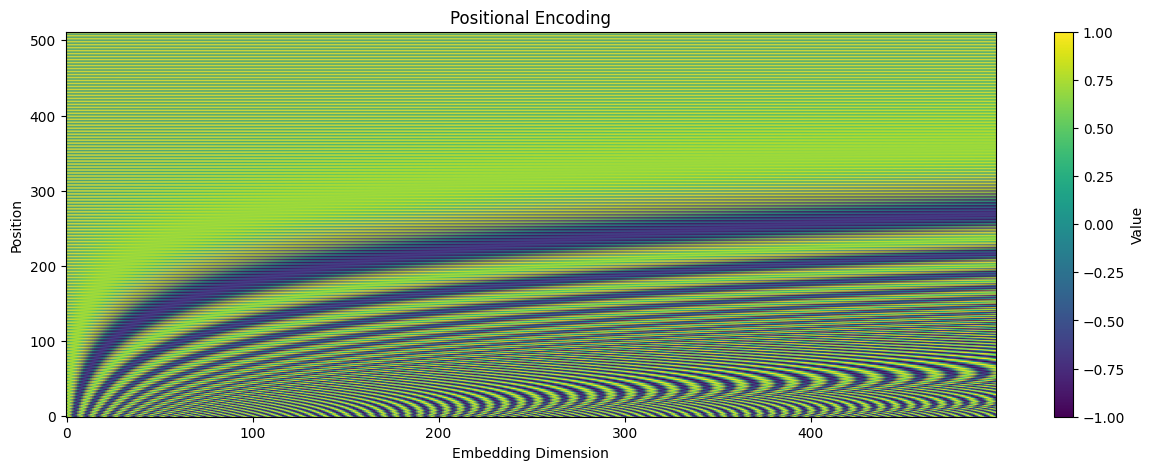

In [264]:
# Let's see how the positional encoding looks like, we also offer a reference image for you to compare.
from util import show_positional_encoding
show_positional_encoding(PositionalEncoding)


## Q 2, Multi-Head Attention (5 Points)
![Alt text](attention.png)


Next, we need to implement the scaled dot-product attention and the multi-head attention.

The attention mechanism can learn a mapping between a query (Q) and a set of key (K) value (V) pairs, where the Q, K, V are the projections from the hidden representation. We use three linear NN layers to model each projection respectively.
The attention is achieved by
Attention $\large (Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$.
In our programming, the shape of Q, K, V are:

 Q: [batch_size, seq_len_q, d_k],

 K: [batch_size, seq_len_k, d_k],

 V: [batch_size, seq_len_k, d_k],

where d_k = d_model.

<div style="border: 1px solid black; padding: 10px; border-radius: 5px; font-style: italic; font-size: 12px;">
    Comment: the meaning of these Q, K, V names can be confusing, because they depend on the particular Natural Language Processing (NLP) application. For developing our transformers you can just think of them as linear projections of the input.
</div>

<div style="border: 1px solid black; padding: 10px; border-radius: 5px; font-style: italic; font-size: 12px;">
    Comment: In transformers, when Q comes from the same sequence as K and V, it is called self-attention. When K and V are from a different sequence than Q, it is called cross-attention.
</div>




---
Additionally, we can have multiple such attention heads, to achieve the multi-head attention, with each head having its own set of Q, K, V parameters. The outputs of these multiple heads are concatenated and linearly transformed to produce the final output. To achieve this, we add one additional dimension to the Q, K, V tensors, which is the number of heads. The data dimension thus get reduced to d_k = d_model / n_head

The shape of the Q, K, V in the multi-head attention are:

 Q: [batch_size, n_head, seq_len_q, d_k],

 K: [batch_size, n_head, seq_len_k, d_k],

 V: [batch_size, n_head, seq_len_k, d_k].

<div style="border: 1px solid black; padding: 10px; border-radius: 5px; font-style: italic; font-size: 12px;">
    Comment: we can consider each attention head in Transformer as a channel used in the CNN, capturing a certain pattern in the data.
</div>

In [ ]:
from util import merge_masks

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int = 512, n_head: int = 8, dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_head == 0
        self.d_model = d_model
        self.n_head = n_head
        self.d_k = d_model // n_head
        self.q_net = nn.Linear(d_model, d_model)
        self.k_net = nn.Linear(d_model, d_model)
        self.v_net = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(p=dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, causal_mask=None, padding_mask=None):
        """
            q: [batch_size, seq_len_q, d_model]
            k: [batch_size, seq_len_k, d_model]
            v: [batch_size, seq_len_k, d_model]
            causal_mask: [seq_len_q, seq_len_k]
            padding_mask: [batch_size, seq_len_k]
            return: [batch_size, seq_len_q, d_model]

            if self attention, q, k, v are the same, and seq_len_q = seq_len_k
            if cross attention, q != k = v, and seq_len_q != seq_len_k

        """

        batch_size = q.shape[0]

        # We need some special care to merge the masks. The mask_ij basically
        # tells if the i-th token in query is allowed to attend to the j-th
        # token in key.
        # The shape of mask is [batch_size, n_head, len_q, len_k] or any shape
        # that can be broadcasted to this shape
        mask = merge_masks(causal_mask, padding_mask, self.n_head)
        
        # Linear projections
        q, k, v = self.q_net(q), self.k_net(k), self.v_net(v)
        
        ####################################################################
        # TODO: Implement the multi-head attention
        # Consider the following steps:
        # 1. Split the Q, K, V into n_head by using torch.view
        # 2. Put the head axis after the batch dimension using torch.transpose
        Q = q.view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        # torch.transpose(Q,1,2)
        K = k.view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        V = v.view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)

        # 3. Calculate the attention scores using Q, K, V
        att_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # 4. Apply the mask to the attention scores by using torch.masked_fill
        att_scores = att_scores.masked_fill(mask, float('-inf'))

        # 5. Apply the softmax function to the attention scores
        att_weights = self.softmax(att_scores)

        # 6. Apply the dropout to the softmax scores to avoid overfitting
        att_weights = self.dropout(att_weights)

        # 7. Multiply the softmax scores with V
        attn = torch.matmul(att_weights, V)
        ####################################################################

        # Concatenate and multiply get processed by the output layer
        # [batch_size, n_head, T, d_k]
        # -> [batch_size, T, n_head, d_k]
        # -> [batch_size, T, n_head * d_k], where n_head * d_k = d_model
        attn = attn.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.output_linear(attn)



## Feed Forward Neural Network
<img src="ff.png" alt="Alt text" width="200">

The feed-forward neural network is used to transform the output of the multi-head attention. It consists of two linear layers with a ReLU activation in between. The implementation has the following code snippet:

In [266]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(torch.relu(self.linear1(x)))
        x = self.linear2(x)
        return x


## Layer Normalization
https://www.pinecone.io/learn/batch-layer-normalization/
<div style="display: flex; flex-direction: row;">
    <div>
        <img src="layer_norm.webp" alt="Image 2" style="width: 300px;"/>
    </div>
    <div style="margin-right: 10px;">
        <img src="batch_norm.webp" alt="Image 1" style="width: 350px;"/>
    </div>
</div>


The transformer architecture uses a layer normalization (left) instead of a batch normalization (right), which is often used in Computer Vision.
The layer normalization is to normalize the input tensor across the feature dimension, which is the last dimension of the tensor.

$y = \gamma ( \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} ) + \beta$

The implementation has the following code snippet:

In [267]:
# Equivalent to torch.nn.LayerNorm(d_model)
class LayerNorm(nn.Module):
    def __init__(self, features: int, eps: float = 1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

## Q 3, Encoder Layer (4 Points)
<img src="encoder_layer.jpg" alt="Alt text" width="200">

The encoder layer consists of one self-attention layer (an instance of MultiHeadAttention) and one feed-forward neural network. The output of each sub-layer is LayerNorm(x + dropout(Sublayer(x))), where Sublayer(x) is the forward function implemented by the sub-layer (MultiHeadAttention or Feedforward) itself.
<div style="border: 1px solid black; padding: 10px; border-radius: 5px; font-style: italic; font-size: 12px;">
    Comment: the lecture slides swapped the order of layer norm and the residual connection. We will update it to stay the same as the original paper.
</div>

In [268]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, causal_mask=None, padding_mask=None):
        """
            src: [batch_size, seq_len, d_model]
            causal_mask: [seq_len, seq_len]
            padding_mask: [batch_size, seq_len]
            return: [batch_size, seq_len, d_model]
        """
        ####################################################################
        # TODO: Implement the encoder layer
        # 1. Multi-Head Attention + Add & Norm
        attn_output = self.self_attn(src, src, src, causal_mask, padding_mask)
        src = self.norm1(src + self.dropout1(attn_output))

        # 2. Feed Forward + Add & Norm
        ffn_output = self.ffn(src)
        src = self.norm2(src + self.dropout2(ffn_output))
        ####################################################################
        return src


## Q 4, Decoder Layer (6 Points)
<img src="decoder_layer.jpg" alt="Alt text" width="200">

The decoder layer consists of three sub-layers: self-attention, cross-attention, and feed-forward neural network. The output of each sub-layer is LayerNorm(x + dropout(Sublayer(x))), where Sublayer(x) is the function implemented by the sub-layer itself.

In [269]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = FeedForward(d_model, d_ff, dropout)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_padding_mask=None, memory_padding_mask=None):
        """
            tgt: [batch_size, seq_len_tgt, d_model]
            memory: [batch_size, seq_len_src, d_model]
            tgt_mask: [seq_len_tgt, seq_len_tgt]
            memory_mask: [seq_len_src, seq_len_src]
            tgt_padding_mask: [batch_size, seq_len_tgt]
            memory_padding_mask: [batch_size, seq_len_src]
            return: [batch_size, seq_len, d_model]"""

        ####################################################################
        # TODO: Implement the decoder layer
        # Consider the following steps:
        # 1. Calculate the self-attention of the target
        attn_output = self.self_attn(tgt, tgt, tgt, tgt_mask, tgt_padding_mask)

        # 2. Add the residual connection, dropout, and apply the layer normalization
        tgt = self.norm1(tgt + self.dropout1(attn_output))

        # 3. Calculate the cross-attention of the target with the memory
        attn_output = self.cross_attn(tgt, memory, memory, memory_mask, memory_padding_mask)

        # 4. Add the residual connection, dropout, and apply the layer normalization
        tgt = self.norm2(tgt + self.dropout2(attn_output))

        # 5. Apply the feed-forward neural network
        ffn_output = self.ffn(tgt)
        
        # 6. Add the residual connection, dropout, and apply the layer normalization
        tgt = self.norm3(tgt + self.dropout3(ffn_output))

        ####################################################################
        return tgt


## Encoder
Encoder is composed of a stack of N identical encoder layers.


In [270]:
class Encoder(nn.Module):
    def __init__(self, d_model, n_head, n_layers, d_ff, dropout=0.1):
        super().__init__()
        self.n_head = n_head
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model, n_head, d_ff, dropout)
             for _ in range(n_layers)])

    def forward(self, src, mask, padding_mask):
        for layer in self.layers:
            src = layer(src, mask, padding_mask)
        return src


## Decoder
Decoder is composed of a stack of N identical decoder layers.

In [271]:
class Decoder(nn.Module):
    def __init__(self, d_model, n_head, n_layers, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model, n_head, d_ff, dropout)
             for _ in range(n_layers)])

    def forward(self, tgt, memory, tgt_mask, memory_mask,
                tgt_padding_mask, memory_padding_mask):
        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask, memory_mask,
                        tgt_padding_mask, memory_padding_mask)
        return tgt


## Transformer
Transformer is composed of the encoder and decoder. We exclude the final linear and softmax layer from the original transformer architecture, so that it stays the same as PyTorch's build-in Transformer implementation. 

In [272]:
class Transformer(nn.Module):
    def __init__(self, d_model, n_head,
                 num_encoder_layers, num_decoder_layers, d_ff):
        super().__init__()
        self.encoder = Encoder(d_model, n_head, num_encoder_layers, d_ff)
        self.decoder = Decoder(d_model, n_head, num_decoder_layers, d_ff)

    def forward(self, src, tgt, src_mask, tgt_mask, memory_mask,
                src_padding_mask, tgt_padding_mask, memory_padding_mask
                ):
        memory = self.encoder(src, src_mask, src_padding_mask)
        output = self.decoder(tgt, memory, tgt_mask, memory_mask,
                              tgt_padding_mask, memory_padding_mask)
        return output


---
## Put Everything Together
We build out transformer translator model by combining the TokenEmbedding, PositionalEncoding, Transformer, and the final linear layer. We define our loss function as the cross-entropy loss. We also define a function to compute the loss of the model on the a mini-batch.

In [273]:
class TransformerTranslator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, emb_size, nhead,
                 num_encoder_layers, num_decoder_layers, dim_feedforward):
        super().__init__()
        
        self.transformer \
            = Transformer(d_model=emb_size, n_head=nhead,
                          num_encoder_layers=num_encoder_layers,
                          num_decoder_layers=num_decoder_layers,
                          d_ff=dim_feedforward)
        
        # If you cannot make your model work, here is the PyTorch's build-in Transformer
        # self.transformer \
        #    = torch.nn.Transformer(d_model=emb_size, nhead=nhead,
        #                  num_encoder_layers=num_encoder_layers,
        #                  num_decoder_layers=num_decoder_layers,
        #                  dim_feedforward=dim_feedforward)
        
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_padding_mask,
                tgt_padding_mask, memory_padding_mask):
        # Get token embeding and positional encoding
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))

        outs = self.transformer(src=src_emb, tgt=tgt_emb, src_mask=src_mask,
                                tgt_mask=tgt_mask, memory_mask=None,
                                src_padding_mask=src_padding_mask,
                                tgt_padding_mask=tgt_padding_mask,
                                memory_padding_mask=memory_padding_mask)

        return self.generator(outs)

In [274]:
from util import create_mask

criterion = nn.CrossEntropyLoss(ignore_index=vocab_en['<pad>'])

# Determine your device. You can use a GPU if it is available, otherwise, use the CPU
# "mps" for MacOS GPU, but your TA does not have a Mac. You may need to try it yourself...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

def compute_loss(model, data_loader, criterion, optimizer=None):
    if optimizer:
        # train mode
        model.train() # train mode: enable dropout
    else:
        # eval mode
        model.eval()  # eval mode: disable dropout
    total_loss = 0
    for src, tgt in data_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]

        # We need to create masks for correct attention behaviour
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input, vocab_de, vocab_en, device)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask,
                       tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[:, 1:]
        loss = criterion(logits.reshape(-1, logits.shape[-1]),
                         tgt_out.reshape(-1))
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

Now, we define our training loop. We use the Adam optimizer with learning rate 1e-4. We train the model for 10 epochs (10min for GPU, 1-2 hours for CPU).

In [ ]:
import torch.optim as optim

model = TransformerTranslator(len(vocab_de), len(vocab_en), 512, 8, 6, 6, 512).to(
    device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

best_valid_loss = float('inf')
for epoch in range(10):  # Train for 10 epochs
    train_loss = compute_loss(model, train_dataloader, criterion, optimizer)

    with torch.no_grad():
        valid_loss = compute_loss(model, valid_dataloader, criterion, optimizer=None)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

        torch.save(model, 'model/model_best.pth')

    print(f'Epoch: {epoch + 1}, Loss: {train_loss}, Val_loss: {valid_loss}')
torch.save(model, 'model/model_last.pth')
print("Training completed!")

1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


After the model training, we can test our model's performance, by translating some German sentences to English. We need a helper function to work with our transformer model, so that the predicted English word can be used again to generate the next word. The following code snippet shows how.

In [ ]:
from util import generate_square_subsequent_mask
import time

# Function to translate sentences
def translate_sentence(sentence, model, vocab_de, vocab_en, tokenizer_de,
                       max_length=50):
    model.eval()
    src = torch.tensor(encode(sentence, vocab_de, tokenizer_de),
                       dtype=torch.long).unsqueeze(0).to(device)
    
    # The translation starts with token <bos>
    tgt = torch.tensor([vocab_en["<bos>"]], dtype=torch.long).unsqueeze(0).to(
        device)

    src_mask = torch.zeros((src.shape[1], src.shape[1]), device=device).type(
        torch.bool)

    memory = model.transformer.encoder(
        model.positional_encoding(model.src_tok_emb(src)), src_mask, None)

    for i in range(max_length):        
        tgt_mask = generate_square_subsequent_mask(tgt.size(1), device)

        out = model.transformer.decoder(
            model.positional_encoding(model.tgt_tok_emb(tgt)), memory, tgt_mask, None, None, None)
        out = model.generator(out[:, -1])
        prob = out.softmax(dim=-1)
        next_word = prob.argmax(dim=-1).item()

        # We append the predicted word to the output sentence
        tgt = torch.cat([tgt, torch.tensor([[next_word]], device=device)],
                        dim=1)
        
        # The translation ends with token <eos>
        if next_word == vocab_en["<eos>"]:
            break

    return decode(tgt.squeeze().tolist(), vocab_en)

In [ ]:
# Given a list of German sentences
german_list = [
    "Eine junge Frau sitzt auf einer Mauer und schaut aufs Meer.",
    "Mehrere Kinder rennen über einen Spielplatz.",
    "Ein älterer Mann geht mit seinem Hund im Park spazieren.",
    "Die Familie sitzt auf der Veranda und isst Frühstück.",
    "Eine Gruppe von Touristen besichtigt eine historische Burg.",
    "Ein Mädchen pflückt Blumen in einem blühenden Garten.",
    "Der Musiker spielt ein Lied auf seiner Geige in der Fußgängerzone.",
    "Die Katze liegt faul auf dem Fensterbrett und sonnt sich.",
    "Das Paar fährt mit dem Fahrrad durch die malerische Landschaft.",
    "Der Koch bereitet ein festliches Abendessen in der Küche vor.",
    "Eine Menschenmenge schaut einem Straßenkünstler zu.",
    "Die Kinder bauen eine Sandburg am Strand.",
    "Der Maler arbeitet an einem neuen Kunstwerk in seinem Atelier.",
    "Eine Frau liest ein Buch unter einem schattigen Baum.",
    "Der Hund jagt einen Ball über die Wiese.",
    "Eine Gruppe von Freunden zeltet in den Bergen.",
    "Der Fotograf macht Bilder von der Skyline der Stadt.",
    "Die Tänzer üben eine Choreografie im Studio.",
    "Der Bauer fährt mit dem Traktor über sein Feld.",
    "Die Schülerin macht ihre Hausaufgaben am Schreibtisch."
]


# Load the model best or last
# use_model = torch.load('model/model_best.pth', weights_only=False)
use_model = torch.load("model/model_last.pth", weights_only=False)

# Translate each sentence in the list
for german_sentence in german_list:
    translation = translate_sentence(german_sentence, use_model, vocab_de, vocab_en,
                                     tokenize_de)
    print(f"German: {german_sentence}")
    print(f"English: {translation}\n")

## Are you happy with the performance?
We offered a reference result in the "reference_result.png" for your comparison. Clearly the translation is not perfect. The model can learn the basic structure of the sentences, but it may not be able to capture the exact meaning. The model can be further improved by using a larger dataset, a larger model, a better structure or finetuning the hyper-parameters. If the sentence is beyond the data distribution, then the model may not be able to translate it at all!

In [ ]:
hard_german_list = ["Die deutsche Fußball-Nationalmannschaft ist mit einem überzeugenden Sieg in die Fußball-Europameisterschaft gestartet.",
                    "Die Auswahl von Bundestrainer Julian Nagelsmann gewann am Freitagabend in München mit 5:1 (3:0) gegen Schottland."]

for german_sentence in hard_german_list:
    translation = translate_sentence(german_sentence, use_model, vocab_de, vocab_en,
                                     tokenize_de)
    print(f"German: {german_sentence}")
    print(f"English: {translation}\n")